/home/itewari1/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/itewari1/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/itewari1/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 - Train Loss: 0.4040 Acc: 73.29%, Val Loss: 3.6918 Acc: 57.14%
Epoch 2 - Train Loss: 0.3751 Acc: 76.60%, Val Loss: 2.9551 Acc: 43.03%


/home/itewari1/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 - Train Loss: 0.2566 Acc: 87.24%, Val Loss: 10.9027 Acc: 57.14%
Epoch 4 - Train Loss: 0.1853 Acc: 92.07%, Val Loss: 7.5468 Acc: 42.86%
Epoch 5 - Train Loss: 0.1150 Acc: 95.40%, Val Loss: 1.6389 Acc: 72.34%
Epoch 6 - Train Loss: 0.0790 Acc: 97.05%, Val Loss: 0.2487 Acc: 89.97%
Epoch 7 - Train Loss: 0.0824 Acc: 97.22%, Val Loss: 0.2319 Acc: 93.77%
Epoch 8 - Train Loss: 0.0594 Acc: 97.80%, Val Loss: 1.6605 Acc: 59.26%
Epoch 9 - Train Loss: 0.0418 Acc: 98.60%, Val Loss: 0.5049 Acc: 80.94%
Epoch 10 - Train Loss: 0.0461 Acc: 98.51%, Val Loss: 0.2513 Acc: 91.69%
Early stopping.


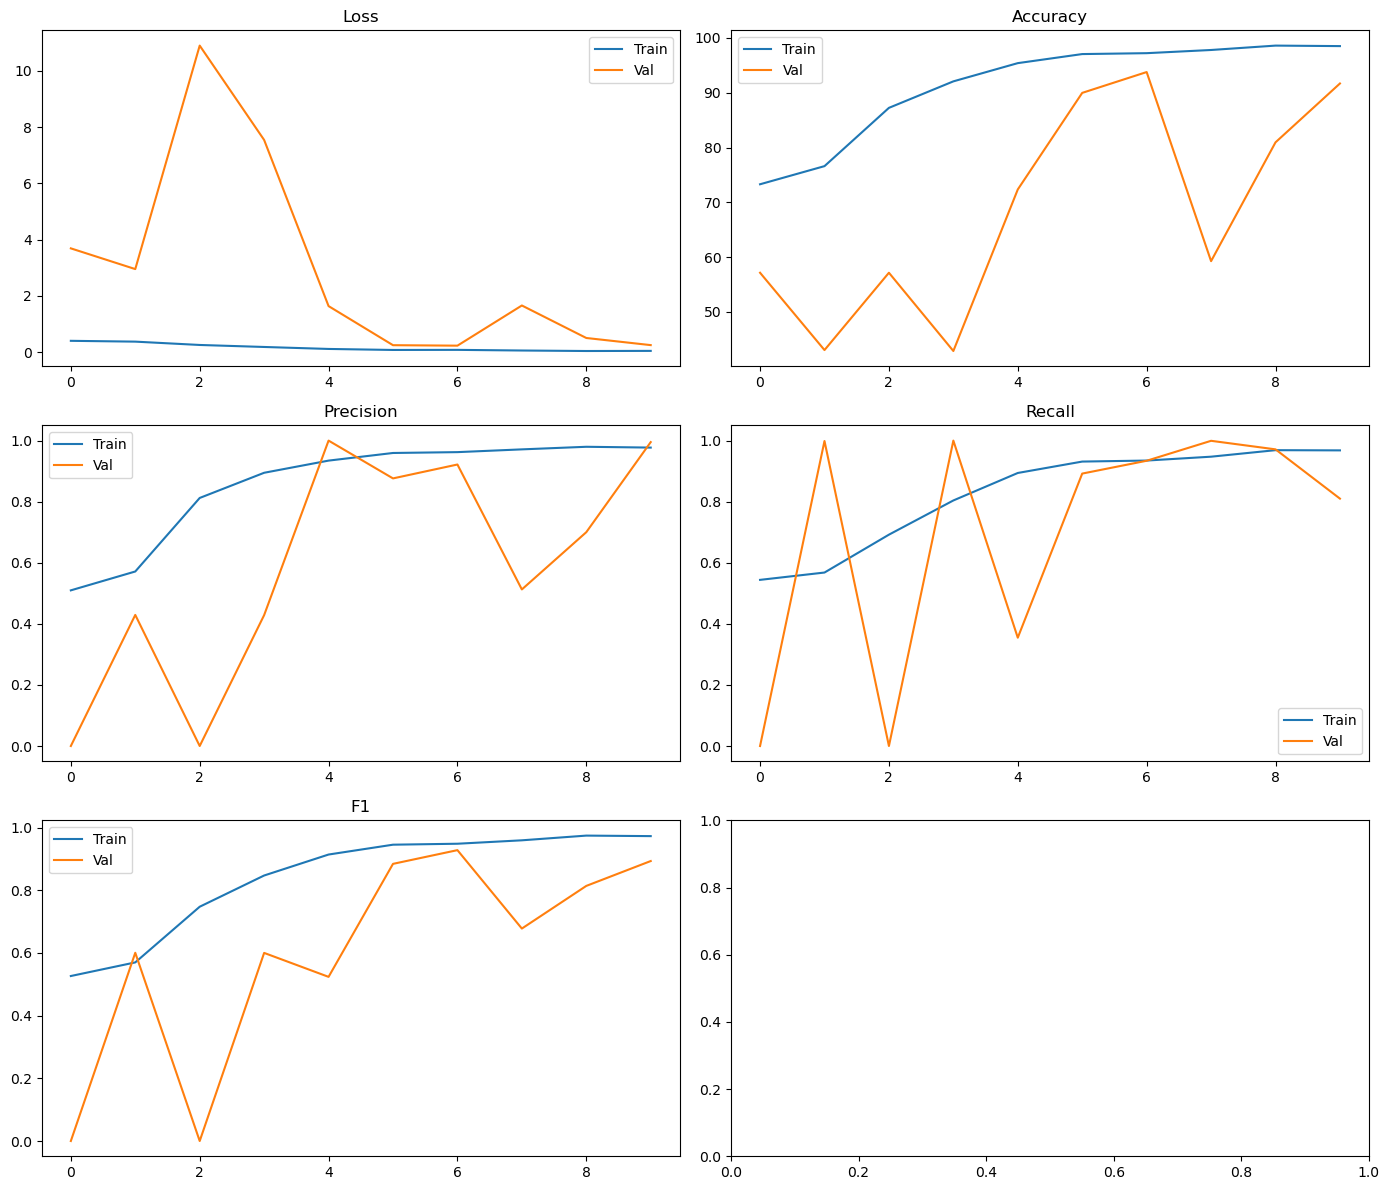

In [4]:
import pandas as pd
import base64
import io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Load and sample data
df1 = pd.read_csv('fraud_crop_replace_image_data.csv')
df2 = pd.read_csv('inpaint_and_rewrite_image_data.csv')
df3 = pd.read_csv('positive_image_data.csv')

df_train = pd.concat([df1.iloc[:1500], df2.iloc[:1500], df3.iloc[:2500]]).sample(frac=1).reset_index(drop=True)
df_test = pd.concat([df1.iloc[1500:], df2.iloc[1500:], df3.iloc[2500:]]).sample(frac=1).reset_index(drop=True)

class FraudDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(base64.b64decode(row['Base64']))).convert('RGB')
        label = 1 if str(row['FRAUD']).strip().upper() == 'TRUE' else 0
        return self.transform(image), label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_loader = DataLoader(FraudDataset(df_train, transform), batch_size=32, shuffle=True)
test_loader = DataLoader(FraudDataset(df_test, transform), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.classifier[3].in_features, 2))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

metrics = lambda: {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
train_metrics, val_metrics = metrics(), metrics()

def evaluate(loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    preds, labels_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_sum += criterion(out, y).item()
            pred = out.argmax(1)
            preds.extend(pred.cpu())
            labels_all.extend(y.cpu())
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    prec = precision_score(labels_all, preds)
    rec = recall_score(labels_all, preds)
    f1 = f1_score(labels_all, preds)
    return loss_sum / len(loader), acc, prec, rec, f1

best_loss, patience, counter = float('inf'), 3, 0

for epoch in range(20):
    model.train()
    total_loss, correct, total = 0, 0, 0
    preds, labels_all = [], []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(1)
        preds.extend(pred.cpu())
        labels_all.extend(y.cpu())
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = 100 * correct / total
    prec = precision_score(labels_all, preds)
    rec = recall_score(labels_all, preds)
    f1 = f1_score(labels_all, preds)
    train_metrics['loss'].append(total_loss / len(train_loader))
    train_metrics['accuracy'].append(acc)
    train_metrics['precision'].append(prec)
    train_metrics['recall'].append(rec)
    train_metrics['f1'].append(f1)

    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(test_loader)
    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_acc)
    val_metrics['precision'].append(val_prec)
    val_metrics['recall'].append(val_rec)
    val_metrics['f1'].append(val_f1)

    print(f"Epoch {epoch+1} - Train Loss: {train_metrics['loss'][-1]:.4f} Acc: {acc:.2f}%, Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.ravel()
for i, key in enumerate(['loss', 'accuracy', 'precision', 'recall', 'f1']):
    axs[i].plot(train_metrics[key], label='Train')
    axs[i].plot(val_metrics[key], label='Val')
    axs[i].set_title(key.capitalize())
    axs[i].legend()
plt.tight_layout()
plt.show()

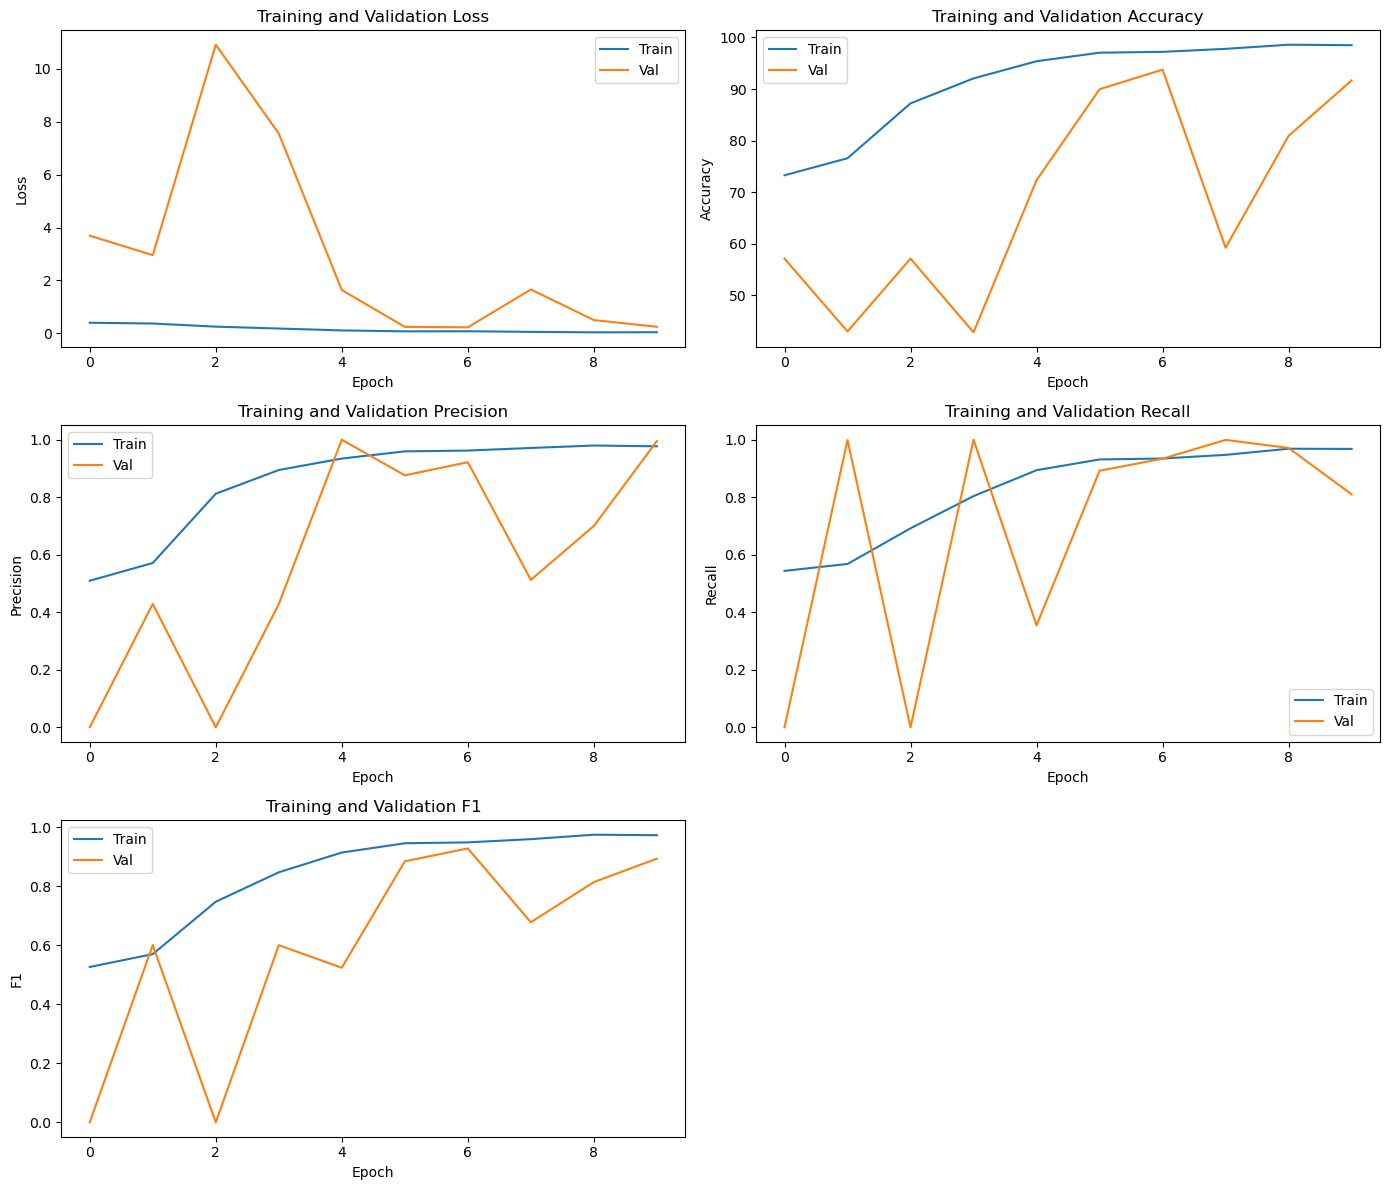

In [7]:
# Plotting with custom headers
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.ravel()
titles = [
    'Training and Validation Loss',
    'Training and Validation Accuracy',
    'Training and Validation Precision',
    'Training and Validation Recall',
    'Training and Validation F1'
]

for i, key in enumerate(['loss', 'accuracy', 'precision', 'recall', 'f1']):
    axs[i].plot(train_metrics[key], label='Train')
    axs[i].plot(val_metrics[key], label='Val')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(key.capitalize())
    axs[i].legend()

# Hide the unused 6th subplot
axs[5].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Optional: Save the model
torch.save(model.state_dict(), "mobileNetV3_fraud_model_3.pth")

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader, class_names=['Non-Fraud', 'Fraud']):
    """
    Plots the confusion matrix for the model on the provided DataLoader.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model
        data_loader (torch.utils.data.DataLoader): DataLoader for evaluation
        class_names (list): List of class names in the order [0, 1]
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()


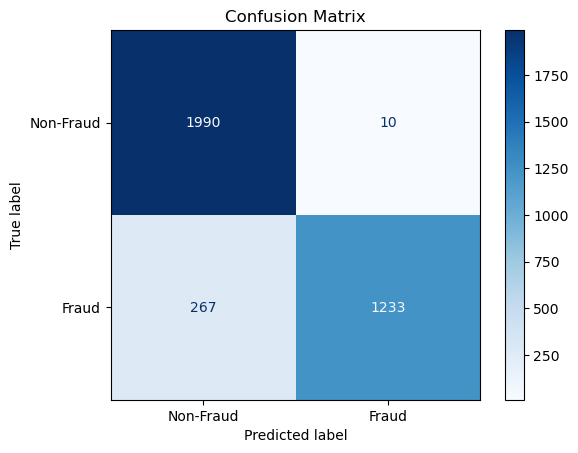

In [9]:
plot_confusion_matrix(model, test_loader)


In [10]:
final_val_accuracy = val_metrics['accuracy'][-1]
final_val_precision = val_metrics['precision'][-1]
final_val_recall = val_metrics['recall'][-1]
final_val_f1 = val_metrics['f1'][-1]

print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")
print(f"Final Validation Precision: {final_val_precision:.4f}")
print(f"Final Validation Recall: {final_val_recall:.4f}")
print(f"Final Validation F1 Score: {final_val_f1:.4f}")

Final Validation Accuracy: 91.69%
Final Validation Precision: 0.9951
Final Validation Recall: 0.8100
Final Validation F1 Score: 0.8931
